<a href="https://colab.research.google.com/github/pr3martins/PyLatheDB/blob/main/demo/PyLatheDB_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyLatheDB - A Library for Relational Keyword Search with Support to Schema References
---

PyLatheDB is based on Lathe, an R-KwS framework that generalizes the well-known concepts of Query Matches (QMs) and Candidate Joining Networks (CJNs) to handle keywords referring to schema elements and introduces new algorithms to generate them, along with a novel approach to automatically select the CJNs that are more likely to represent the user intent when issuing a keyword query.

We recommend running this Python Notebook using [Google Colab](https://colab.research.google.com/github/pr3martins/PyLatheDB/blob/main/demo/PyLatheDB_DEMO.ipynb). But its static version is also available in our [GitHub Repository](https://github.com/pr3martins/PyLatheDB/blob/main/demo/PyLatheDB_DEMO.ipynb).

## Environment Preparation

Initially, before the demonstration, it is necessary to  run an environment preparation step, which includes the installation of the RDBMS; the downloading of some configuration files and scripts; and the installation of the **PyLatheDB** library and its dependencies.

### Download of the configuration Files

In [ ]:
!gdown --id 1KTRL-RhKgnzENlwcGHZ7zkvT4fVsQ1D7
!unzip PyLatheDB_DEMO_resources.zip
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
!cp dbsources/pylathedb.stop /usr/share/postgresql/10/tsearch_data/english.stop

### Installation of the PostgreSQL

In [ ]:
# Install postgresql server
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql postgresql-contrib &>log
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"


### Scripts for the Databases Creation

In [ ]:
!sudo -u postgres dropdb imdb
!sudo -u postgres createdb imdb
!sudo -u postgres psql -U postgres imdb <  dbsources/imdb-schema.pgsql
!sudo -u postgres psql -U postgres imdb <  dbsources/imdb-data.pgsql &>log
!sudo -u postgres psql -U postgres imdb <  dbsources/imdb-fulltext_index.psql
!sudo -u postgres psql -U postgres imdb < dbsources/imdb-rename-tables.psql

!sudo -u postgres dropdb mondial
!sudo -u postgres createdb mondial
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-schema_part1.pgsql
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-data.pgsql &>log
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-schema_part2.pgsql
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-field_fulltext_index.psql

### Enable DataTable Formating from Google Colab

In [4]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

### Installation of the PyLathe library available [here](https://pypi.org/project/pylathedb/)

In [ ]:
!pip install pylathedb==1.0.3 -U

## PyLatheDB setup

In this section, we will run the PyLatheDB setup, which comprises the creation of the Value Index and the Schema Index. We will also explain the main parameters of the library, such as number of QMs, number of CJNs per QM and the use of the eager evaluation strategy for CJN generation. 

### Library import and set configuration directory

In [1]:
from pylathedb.lathe import Lathe
lathe = Lathe(config_directory='./config/')

### Create Indexes 
This step is not necessary because we already downloaded the indexes alongside the configuration files. But feel free to test the Index Creation uncommenting the following cell:

In [2]:
# lathe.create_indexes()

### Load Indexes

The cell below shows how to load the Value and Schema Indexes.

In [3]:
lathe.load_indexes()

### Choose Query set/Database

You can choose which query set to use and its respective database. Input as a function parameter the number of the name of the query set to use. If you input no number, it will list the query sets available.

In [4]:
lathe.change_queryset()

Please input a query set to change:
01 - coffman_mondial
02 - coffman_imdb


In [7]:
lathe.change_queryset('coffman_imdb')

./config/queryset_configs/coffman_imdb_config.json
Changed to query set coffman_imdb.


### Default Parameters

We have a few parameters for R-KwS using PyLatheDB:
*    `max_qm_size`: Maximum Query Match Size
*    `max_cjn_size`: Maximum Candidate Joining Network Size
*    `topk_cns`: Top-k CJNs to be considered
*    `configuration`: A tuple containing the number of QMs to be considered, number of CJNs for each QM to be considered, and the maximum number of CJNs to be probed by the eager evaluation for each QM. 




In [8]:
lathe.max_qm_size = 3
lathe.max_cjn_size = 5
lathe.topk_cns = 10
lathe.configuration = (5,1,9)

## Keyword Search over Relational Databases

You can use the function `keyword_search` from the class `Lathe` using three parameters. 


1.   You can input a Keyword query
2.   You can call the function with no input to show a list of premade keyword queries used in Coffman Benchmark.
3.   You can input the number of the keyword query according to the option 2.

In [9]:
lathe.keyword_search()

Please input a keyword query or choose one of the queries below:
01 - denzel washington
02 - clint eastwood
03 - john wayne
04 - will smith
05 - harrison ford
06 - julia roberts
07 - tom hanks
08 - johnny depp
09 - angelina jolie
10 - morgan freeman
11 - gone with the wind
12 - star wars
13 - casablanca
14 - lord of the rings
15 - the sound of music
16 - wizard of oz
17 - the notebook
18 - forrest gump
19 - the princess bride
20 - the godfather
21 - title atticus finch
22 - title indiana jones
23 - title james bond
24 - title rick blaine
25 - title will kane
26 - title dr. hannibal lecter
27 - title norman bates
28 - title darth vader
29 - title the wicked witch of the west
30 - title nurse ratched
31 - title frankly my dear i don't give a damn
32 - title i'm going to make him an offer he can't refuse
33 - title you don't understand i coulda had class i coulda been a contender i coulda been somebody instead of a bum which is what i am
34 - title toto i've a feeling we're not in kansas 

### Understanding the Results

The function `keyword_search` from the class `Lathe` returns an `LatheResult` object, which contains methods to show the CJNs, QMs and KMs returned for the keyword query.

#### Candidate Joining Networks

The library returns, for each CJN, its Text representation, its Graph representation, its SQL translation and the returned results from the SQL execution by the RDBMS. The function `cjns` outputs the informatio about each CJN according to four boolean parameters: `text`, `graph`, `sql`, and `jnts`. All of them are enabled by default.


*The Graph representation is not available in the static version of this notebook in Github. You can run it using Google Colab.*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pr3martins/PyLatheDB/blob/main/demo/PyLatheDB_DEMO.ipynb)

Keyword Query: julia roberts films


---

**1st CJN**:

---

Text:
	PERSON.v(name{julia,roberts})
		<CASTING
			>MOVIE.s(*{films})


---

Graph:


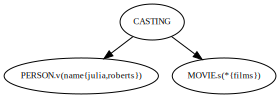

---

SQL:
  
  SELECT
  	t1.name,
  	t3.*
  FROM
  	person t1
  	JOIN casting t2 ON t2.person_id = t1.id
  	JOIN movie t3 ON t2.movie_id = t3.id
  WHERE
  	t1.name_tsvector @@ to_tsquery('julia & roberts')
  LIMIT 1000;



---

JNTs:


,name,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id
0,"Roberts, Julia",3161,20 Something,None,1,2006,None,S5352,None,None,None,None,43788412
1,"Roberts, Julia",462275,Stepmom,None,1,1998,None,S315,None,None,None,None,44222915
2,"Roberts, Julia",263386,Kit Kittredge: An American Girl,None,1,2008,None,K3236,None,None,None,None,43982791
3,"Roberts, Julia",428985,Satisfaction,None,1,1988,None,S3212,None,None,None,None,44196668
4,"Roberts, Julia",337406,Monte Carlo,None,1,2010,None,M5326,None,None,None,None,44056231


---

**2nd CJN**:

---

Text:
	MOVIE.s(*{films}).v(title{julia,roberts})


---

Graph:


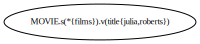

---

SQL:
  
  SELECT
  	t1.title,
  	t1.*
  FROM
  	movie t1
  WHERE
  	t1.title_tsvector @@ to_tsquery('julia & roberts')
  LIMIT 1000;



---

JNTs:


,title,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id
0,Untitled Julia Roberts/Joan Root Project,567842,Untitled Julia Roberts/Joan Root Project,None,1,2009,None,U5343,None,None,None,None,44309348


---

**3rd CJN**:

---

Text:
	MOVIEINFO.v(info{julia,roberts})
		>MOVIE.s(*{films})


---

Graph:


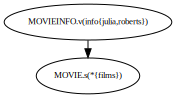

---

SQL:
  
  SELECT
  	t2.*,
  	t1.info
  FROM
  	movieinfo t1
  	JOIN movie t2 ON t1.movie_id = t2.id
  WHERE
  	t1.info_tsvector @@ to_tsquery('julia & roberts')
  LIMIT 1000;



---

JNTs:


,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id,info
0,263267,Kiss the Bride,None,1,2007,None,K2316,None,None,None,None,43995987,Stephanie: You totally love him. You want to w...
1,364762,Ocean's Twelve,None,1,2004,None,O2523,None,None,None,None,44054612,[to Tess while she is pretending to be Julia R...
2,364762,Ocean's Twelve,None,1,2004,None,O2523,None,None,None,None,44054612,Tess Ocean: [while trying to get through a cro...
3,364762,Ocean's Twelve,None,1,2004,None,O2523,None,None,None,None,44054612,Tess Ocean: Ma Marcus?::Julia Roberts: Um... N...
4,523654,The Prestige,None,1,2006,None,P6232,None,None,None,None,44264635,Julia McCullough: I thought up a name for you:...


---

**4th CJN**:

---

Text:
	PERSON.v(name{julia})
		<CASTING
			>MOVIE.s(*{films})
				<CASTING
					>PERSON.v(name{roberts})


---

Graph:


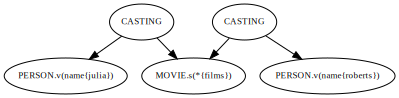

---

SQL:
  
  SELECT
  	t5.name,
  	t1.name,
  	t3.*
  FROM
  	person t1
  	JOIN casting t2 ON t2.person_id = t1.id
  	JOIN movie t3 ON t2.movie_id = t3.id
  	JOIN casting t4 ON t4.movie_id = t3.id
  	JOIN person t5 ON t4.person_id = t5.id
  WHERE
  	t1.ctid <> t5.ctid
  	AND t2.ctid <> t4.ctid
  	AND t1.name_tsvector @@ to_tsquery('julia')
  	AND t5.name_tsvector @@ to_tsquery('roberts')
  LIMIT 1000;



---

JNTs:


,name,name,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id
0,"Kurcz, Robert","Pistor, Julia",345347,My Suicide,None,1,2008,None,M23,None,None,None,None,44054280
1,"Kessel, Robert","Rask, Julia",10579,A Home at the End of the World,None,1,2004,None,H5353,None,None,None,None,43812206
2,"Roberts, Shawn","Rask, Julia",10579,A Home at the End of the World,None,1,2004,None,H5353,None,None,None,None,43812206
3,"Roberts, Dallas","Rask, Julia",10579,A Home at the End of the World,None,1,2004,None,H5353,None,None,None,None,43812206
4,"Tierney, Robert","Child, Julia",252277,Julie & Julia,None,1,2009,None,J424,None,None,None,None,43947730


---

**5th CJN**:

---

Text:
	PERSON.v(name{julia,roberts})
		<CASTING
			>CHARACTER
				<CASTING
					>MOVIE.v(title{films})


---

Graph:


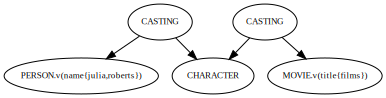

---

SQL:
  
  SELECT
  	t5.title,
  	t1.name
  FROM
  	person t1
  	JOIN casting t2 ON t2.person_id = t1.id
  	JOIN character t3 ON t2.person_role_id = t3.id
  	JOIN casting t4 ON t4.person_role_id = t3.id
  	JOIN movie t5 ON t4.movie_id = t5.id
  WHERE
  	t2.ctid <> t4.ctid
  	AND t1.name_tsvector @@ to_tsquery('julia & roberts')
  	AND t5.title_tsvector @@ to_tsquery('films')
  LIMIT 1000;



---

JNTs:


,title,name
0,The Film That Was Lost,"Roberts, Julia"
1,Going to Pieces: The Rise and Fall of the Slas...,"Roberts, Julia"
2,The Fantasy Film Worlds of George Pal,"Roberts, Julia"
3,The Making of a Horror Film,"Roberts, Julia"
4,Thirty Two Short Films About Glenn Gould,"Roberts, Julia"


In [11]:
result = lathe.keyword_search('julia roberts films')
result.cjns()

### Query Matches

The function `qms` returns a ranked list of the Query Matches for the keyword query. Each QM is presented as a set of Keyword Matches.

In [12]:
result.qms()

---

**1st QM**:

---

{MOVIE.s(*{films}), PERSON.v(name{julia,roberts})}


---

**2nd QM**:

---

{MOVIE.s(*{films}).v(title{julia,roberts})}


---

**3rd QM**:

---

{MOVIE.s(*{films}), MOVIEINFO.v(info{julia,roberts})}


---

**4th QM**:

---

{MOVIE.s(*{films}), PERSON.v(name{roberts}), PERSON.v(name{julia})}


---

**5th QM**:

---

{MOVIE.v(title{films}), PERSON.v(name{julia,roberts})}


### Keyword Matches

The function `kms` returns two unordered lists, one for the Schema-Keyword Matches and one for Value-Keyword Matches.

In [13]:
result.kms()

---

**SKMs**:

---

MOVIE.s(*{films})


---

**VKMs**:

---

MOVIEINFO.v(info{julia})
PERSON.v(name{julia})
CHARACTER.v(name{julia})
MOVIE.v(title{julia})
MOVIEINFO.v(info{roberts})
PERSON.v(name{roberts})
CHARACTER.v(name{roberts})
MOVIE.v(title{roberts})
MOVIEINFO.v(info{films})
CHARACTER.v(name{films})
MOVIE.v(title{films})
MOVIEINFO.v(info{julia,roberts})
MOVIEINFO.v(info{julia,films})
PERSON.v(name{julia,roberts})
MOVIE.v(title{julia,roberts})


Keyword Query: john travolta olivia films


---

**1st CJN**:

---

Text:
	PERSON.v(name{john,olivia})
		<CASTING
			>MOVIE.s(*{films})
				<CASTING
					>PERSON.v(name{john,travolta})


---

Graph:


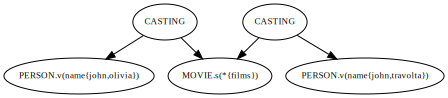

---

SQL:
  
  SELECT
  	t5.name,
  	t1.name,
  	t3.*
  FROM
  	person t1
  	JOIN casting t2 ON t2.person_id = t1.id
  	JOIN movie t3 ON t2.movie_id = t3.id
  	JOIN casting t4 ON t4.movie_id = t3.id
  	JOIN person t5 ON t4.person_id = t5.id
  WHERE
  	t1.ctid <> t5.ctid
  	AND t2.ctid <> t4.ctid
  	AND t1.name_tsvector @@ to_tsquery('john & olivia')
  	AND t5.name_tsvector @@ to_tsquery('john & travolta')
  LIMIT 1000;



---

JNTs:


,name,name,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id
0,"Travolta, John","Newton-John, Olivia",199214,Grease,None,1,1978,None,G62,None,None,None,None,43908386
1,"Travolta, John","Newton-John, Olivia",559385,Two of a Kind,None,1,1983,None,T1253,None,None,None,None,44303665
2,"Travolta, John","Newton-John, Olivia",504851,The Guru,None,1,2002,None,G6,None,None,None,None,44255543


---

**2nd CJN**:

---

Text:
	MOVIEINFO.v(info{john,travolta,olivia})
		>MOVIE.s(*{films})


---

Graph:


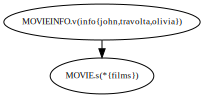

---

SQL:
  
  SELECT
  	t2.*,
  	t1.info
  FROM
  	movieinfo t1
  	JOIN movie t2 ON t1.movie_id = t2.id
  WHERE
  	t1.info_tsvector @@ to_tsquery('john & travolta & olivia')
  LIMIT 1000;



---

JNTs:


,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id,info
0,510494,The Last Days of Disco,None,1,1998,None,L2321,None,None,None,None,44283571,Josh Neff: Disco will never be over. It will a...


In [14]:
results = lathe.keyword_search('john travolta olivia films')
results.cjns()

In [15]:
results = lathe.keyword_search(38)
results.cjns(text=True,graph=False,sql=True,df=False)

Keyword Query: henry fonda yours mine ours character


---

**1st CJN**:

---

Text:
	PERSON.v(name{henry,fonda})
		<CASTING
			>MOVIE.v(title{mine})
			>ROLE.s(*{character})


---

SQL:
  
  SELECT
  	t1.name,
  	t4.*,
  	t3.title
  FROM
  	person t1
  	JOIN casting t2 ON t2.person_id = t1.id
  	JOIN movie t3 ON t2.movie_id = t3.id
  	JOIN role t4 ON t2.role_id = t4.id
  WHERE
  	t1.name_tsvector @@ to_tsquery('henry & fonda')
  	AND t3.title_tsvector @@ to_tsquery('mine')
  LIMIT 1000;


